In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%pylab inline
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Визуальный анализ

        month  WAG_C_M
0  01.01.1993     15.3
1  01.02.1993     19.1
2  01.03.1993     23.6
3  01.04.1993     30.6
4  01.05.1993     37.5
(284, 2)
WAG_C_M    float64
dtype: object


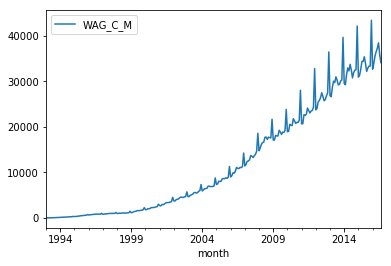

In [2]:
payroll = pd.read_csv('WAG_C_M.csv', sep=';')
print(payroll.head())
print(payroll.shape)
payroll['month'] = pd.to_datetime(payroll['month'], format='%d.%m.%Y')
payroll.set_index(keys='month', inplace=True)
print(payroll.dtypes)

payroll.plot()


Критерий Дики-Фуллера о станционарности ряда: p=0.991850


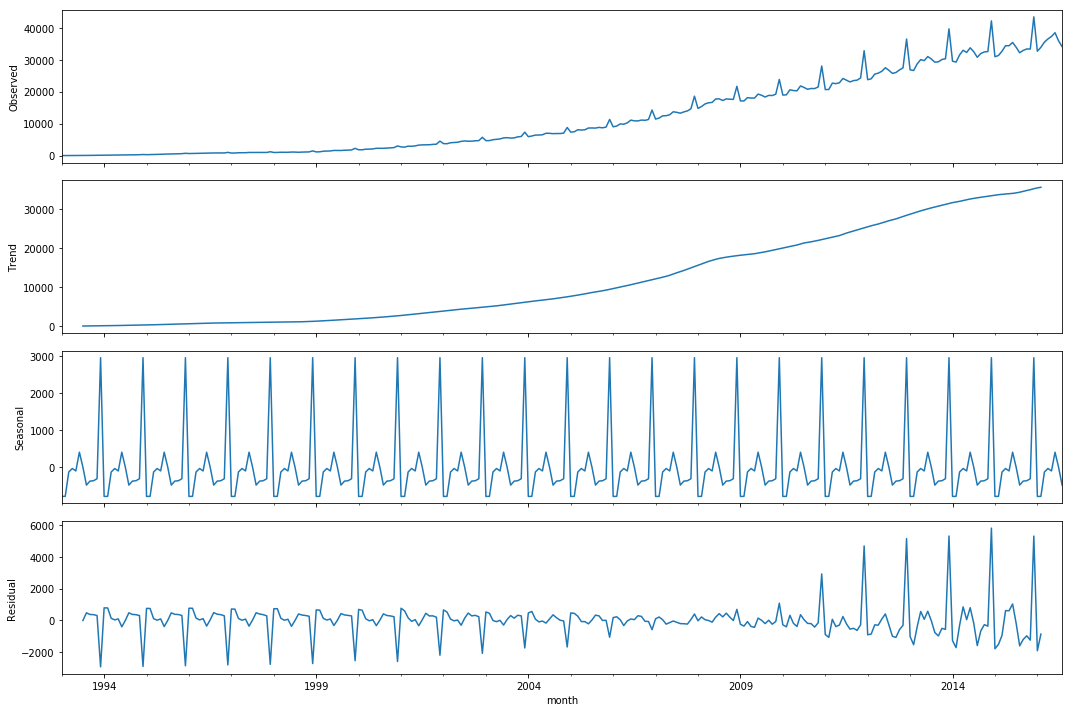

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(payroll).plot()
print("Критерий Дики-Фуллера о станционарности ряда: p=%f" % sm.tsa.stattools.adfuller(payroll['WAG_C_M'])[1])

# Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


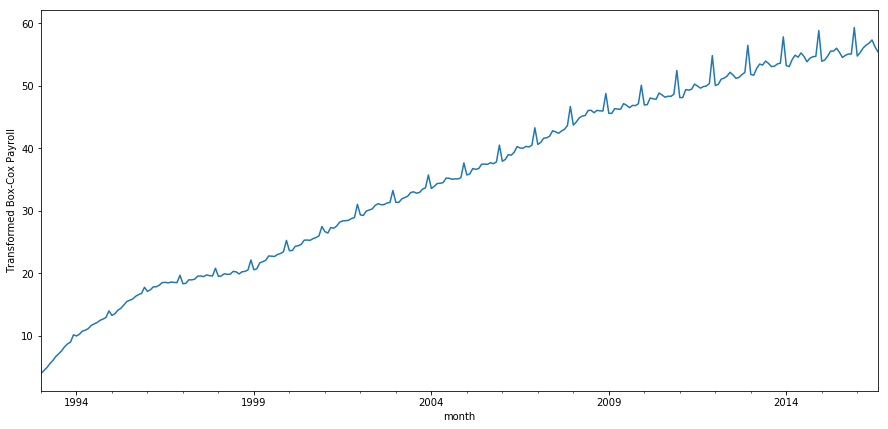

In [3]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
payroll['WAG_C_M_box'], lmbda = stats.boxcox(payroll['WAG_C_M'])
plt.figure(figsize(15,7))
payroll['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed Box-Cox Payroll')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payroll['WAG_C_M_box'])[1])

# Выбор порядка дифференцирования (d, D)

Критерий Дики-Фуллера: p=0.014697


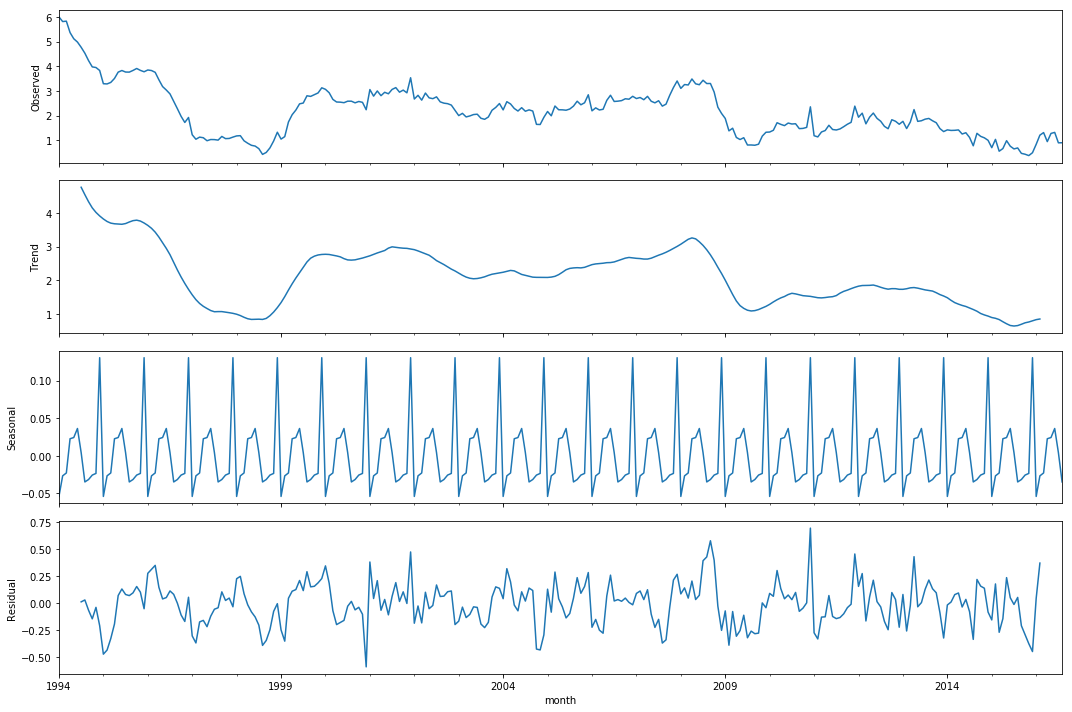

In [4]:
payroll['WAG_C_M_box_diff12'] = payroll['WAG_C_M_box'] - payroll['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(payroll['WAG_C_M_box_diff12'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payroll['WAG_C_M_box_diff12'][12:])[1])
D = 1
d = 0

# Выбор начальных приближений для p,q,P,Q

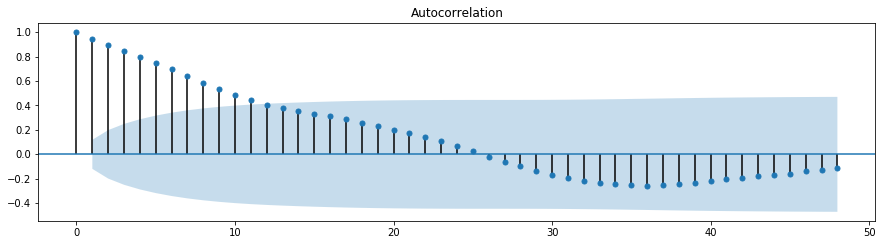

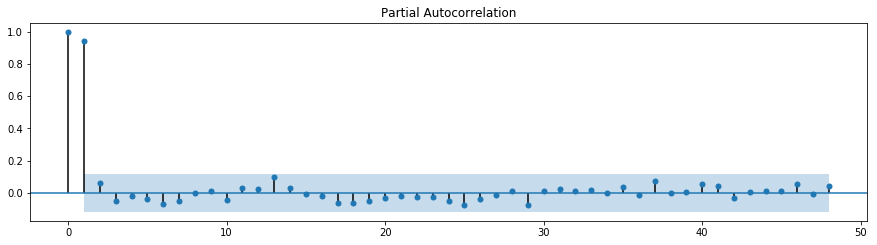

In [6]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(payroll['WAG_C_M_box_diff12'][12:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(payroll['WAG_C_M_box_diff12'][12:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [5]:
Q = range(0,1)
q = range(0,11)
P = range(0,1)
p = range(0,2)

# Обучение и сравнение моделей-кандидатов, выбор победителя

In [6]:
%%time
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(payroll['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print()
print('Лучшая модель')
print(best_model.summary())

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 3, 0, 0))
('wrong parameters:', (0, 4, 0, 0))
('wrong parameters:', (0, 5, 0, 0))
('wrong parameters:', (0, 6, 0, 0))
('wrong parameters:', (0, 7, 0, 0))
('wrong parameters:', (0, 8, 0, 0))
('wrong parameters:', (0, 9, 0, 0))
('wrong parameters:', (0, 10, 0, 0))
       parameters       aic
11   (1, 9, 0, 0) -7.879236
12  (1, 10, 0, 0) -6.586142
10   (1, 8, 0, 0) -4.342940
9    (1, 7, 0, 0) -2.680361
8    (1, 6, 0, 0) -2.650117
()
Лучшая модель
                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                  14.940
Date:                            Wed, 08 Nov 2017   AIC                             -7.879
Time:                                    12:42:15   BIC                             32.259
Sample:                            

# Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.

Критерий Стьюдента: p=0.392014
Критерий Дики-Фуллера: p=0.000000


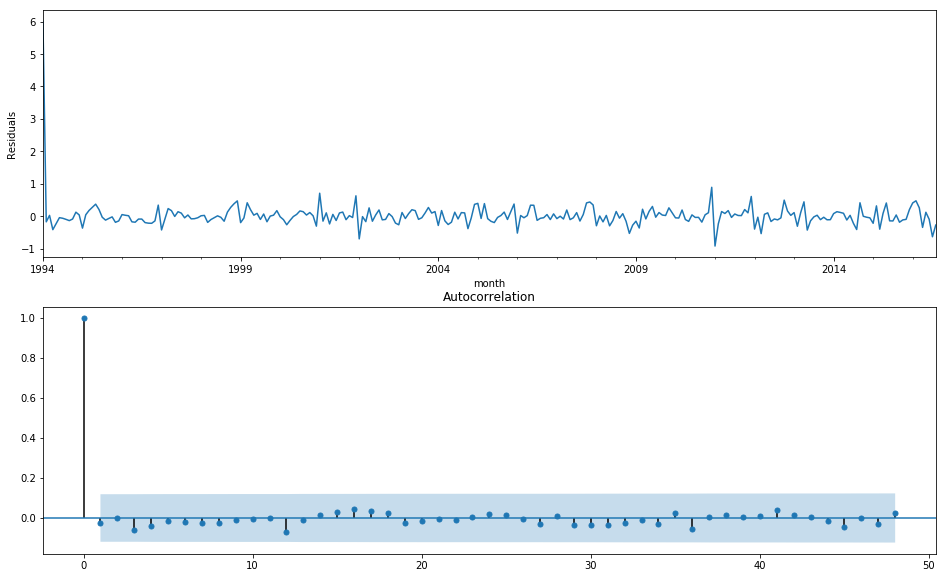

In [14]:
plt.figure(figsize(16,10))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

In [15]:
# ошибки не смещены и станционарны

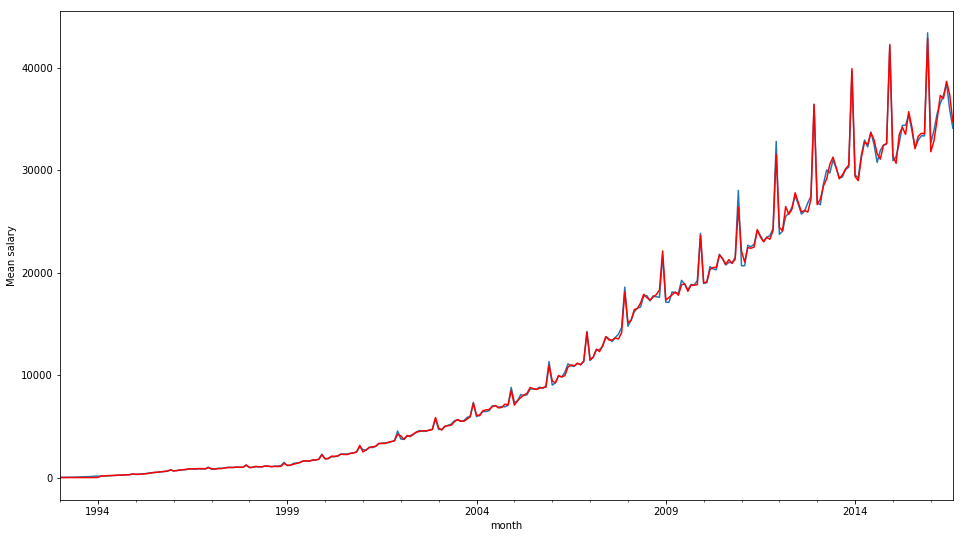

In [7]:
payroll['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(16, 9))
payroll['WAG_C_M'].plot()
payroll['model'].dropna().plot(color='r')
plt.ylabel('Mean salary')
plt.show()

# Прогнозирование с помощью финальной модели

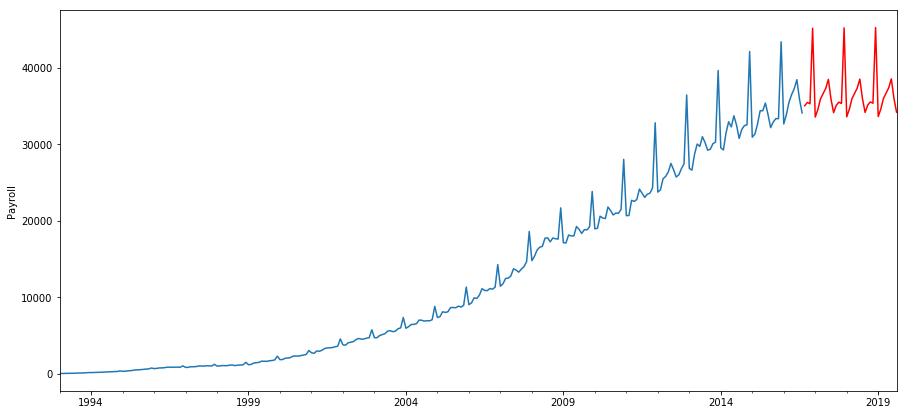

In [18]:
payroll2 = payroll[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=payroll2.columns)
payroll2 = pd.concat([payroll2, future])
payroll2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
payroll2['WAG_C_M'].plot()
payroll2['forecast'].plot(color='r')
plt.ylabel('Payroll')
pylab.show()